In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.quantum_info import Operator, SparsePauliOp
from vqls_prototype import VQLS, VQLSLog
from vqls_prototype import Hybrid_QST_VQLS, QST_VQLS
from qiskit.primitives import Estimator, Sampler 
from vqls_prototype.hadamard_test.direct_hadamard_test import BatchDirectHadammardTest
from vqls_prototype.hadamard_test.hadamard_test import BatchHadammardTest
from vqls_prototype.matrix_decomposition.optimized_matrix_decomposition import OptimizedPauliDecomposition, ContractedPauliDecomposition

In [2]:
N = 4

num_qubits = int(np.log2(N))
A = -0.5*np.random.rand(N,N)
A = A + A.T 

b = -0.5*np.random.rand(N)
b /= np.linalg.norm(b)


In [3]:
from qiskit.circuit.library.n_local.real_amplitudes import RealAmplitudes
from qiskit.circuit.library.n_local.efficient_su2 import EfficientSU2

ansatz = RealAmplitudes(num_qubits, entanglement='full', reps=3, insert_barriers=False)
# ansatz = EfficientSU2(num_qubits, reps=1, entanglement='reverse_linear', insert_barriers=False)

In [4]:
ansatz.decompose().draw()

┌──────────┐     ┌──────────┐     ┌──────────┐     ┌──────────┐
q_0: ┤ Ry(θ[0]) ├──■──┤ Ry(θ[2]) ├──■──┤ Ry(θ[4]) ├──■──┤ Ry(θ[6]) ├
     ├──────────┤┌─┴─┐├──────────┤┌─┴─┐├──────────┤┌─┴─┐├──────────┤
q_1: ┤ Ry(θ[1]) ├┤ X ├┤ Ry(θ[3]) ├┤ X ├┤ Ry(θ[5]) ├┤ X ├┤ Ry(θ[7]) ├
     └──────────┘└───┘└──────────┘└───┘└──────────┘└───┘└──────────┘

In [5]:
from qiskit.algorithms import optimizers as opt
optimizer = opt.COBYLA(maxiter=250)

In [6]:
num_parameters = ansatz.num_parameters
parameters = 4*np.pi*np.random.rand(num_parameters)

In [7]:
log = VQLSLog([], [])
estimator_noisefree = Estimator()
sampler_noisefree = Sampler()
vqls = VQLS(estimator_noisefree, ansatz, optimizer, sampler=sampler_noisefree, callback=log.update)
vqls_options = vqls._validate_solve_options({"matrix_decomposition":'pauli', 
                                             'shots':None})


hdmr_tests_norm, hdmr_tests_overlap = vqls.construct_circuit(A, b, vqls_options)
hdmr_norm_values = BatchHadammardTest(hdmr_tests_norm).get_values(estimator_noisefree, parameters)
hdmr_overlap_values = BatchHadammardTest(hdmr_tests_overlap).get_values(estimator_noisefree, parameters)

coefficient_matrix = vqls.get_coefficient_matrix(np.array([mat_i.coeff for mat_i in vqls.matrix_circuits]))
vqls_cost = vqls.get_cost_evaluation_function(
    hdmr_tests_norm, hdmr_tests_overlap, coefficient_matrix, vqls_options
)
vqls_cost(parameters)

0.48228388023703894

In [8]:
hybrid_qst_vqls = Hybrid_QST_VQLS(estimator_noisefree, ansatz, optimizer, sampler_noisefree, callback=log.update)
hybrid_qst_vqls._init_tomography('htree')
norm_circuits, overlap_circuits = hybrid_qst_vqls.construct_circuit(A, b, {'tomography':'htree', 'shots':None})
samples = BatchDirectHadammardTest(norm_circuits).get_values(sampler_noisefree, parameters)

hdmr_values_norm_mo = hybrid_qst_vqls.matrix_circuits.get_norm_values(samples)

samples = BatchDirectHadammardTest(overlap_circuits).get_values(sampler_noisefree, parameters)
sign_ansatz = hybrid_qst_vqls.tomography_calculator.get_relative_amplitude_sign(parameters)
hdmr_values_overlap_mo = hybrid_qst_vqls.matrix_circuits.get_overlap_values(
                samples, sign_ansatz
            )

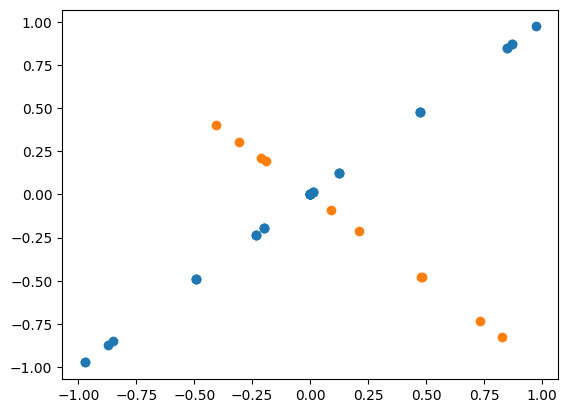

In [9]:
plt.scatter(np.real(hdmr_norm_values), np.real(hdmr_values_norm_mo))
plt.scatter(np.real(hdmr_overlap_values), np.real(hdmr_values_overlap_mo))


In [10]:
coefficient_matrix = hybrid_qst_vqls.get_coefficient_matrix(np.array([mat_i.coeff for mat_i in vqls.matrix_circuits]))
vqls_cost = hybrid_qst_vqls.get_cost_evaluation_function(
    norm_circuits, overlap_circuits, coefficient_matrix, vqls_options
)
vqls_cost(parameters)

0.4822838802370282

In [11]:
qst_vqls = QST_VQLS(estimator_noisefree, ansatz, optimizer, sampler_noisefree, callback=log.update)
qst_vqls.initialize_tomography_calculator('htree')
qst_vqls.preprocessing_matrices(A, b)

statevector = qst_vqls.tomography_calculator.get_statevector(parameters)


hdmr_values_norm_mo = qst_vqls.get_norm_values(statevector)
hdmr_values_overlap_mo = qst_vqls.get_overlap_values(statevector)


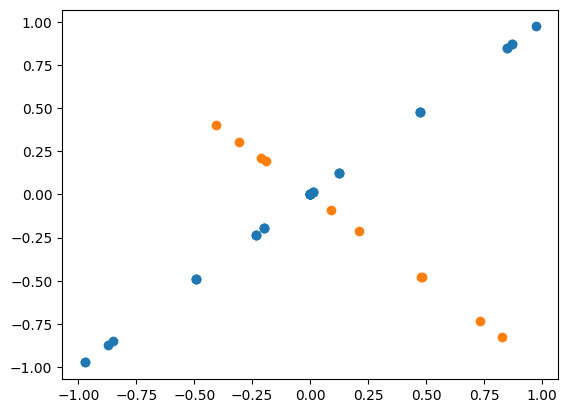

In [12]:
plt.scatter(np.real(hdmr_norm_values), np.real(hdmr_values_norm_mo))
plt.scatter(np.real(hdmr_overlap_values), np.real(hdmr_values_overlap_mo))


In [13]:
coefficient_matrix = qst_vqls.get_coefficient_matrix(np.array([mat_i.coeff for mat_i in vqls.matrix_circuits]))
vqls_cost = qst_vqls.get_cost_evaluation_function(coefficient_matrix, vqls_options)
vqls_cost(parameters)

0.4822838802370282

In [15]:
qst_vqls.solve(A,b)